<a href="https://colab.research.google.com/github/forsp/dig_proc_lect/blob/main/fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация алгоритма Быстрого Преобразования Фурье (FFT - Fast Fourier Transform)

Быстрое преобразование Фурье (БПФ — англ. FFT) является одним из важнейших алгоритмов обработки сигналов и анализа данных. Оно реализует дискретное преобразование Фурье (ДПФ) сигнала за счет меньшего числа математических операций, чем требуется по стандартным формулам. 

Ввиду важности БПФ, реализации данного алгоритма есть в инструментариях большинства языков программирования (Matlab, C, Fortran, Python и пр). Так, библиотеки numpy и scipy языка программирования Python имеют встроенные функции для вычисления БПФ, которые находятся в подмодулях numpy.fft и scipy.fftpack соответственно.

Рассмотрим принцип реализации БПФ.

## 1. Вычисление дискретного преобразования Фурье (ДПФ)

Итак, преобразование Фурье $x[n] \rightarrow X[k]$ является переводом из временного пространства в пространство частотное по формуле:


$$
    X[k] = \sum_{n=0}^{N-1} x[n]\, e^{-j\frac{2\pi}{N}nk}, \quad k=0, \ldots, N-1 
$$

Обратное преобразование (ОДПФ), соответственно:

$$
    x[n] = \frac{1}{N}\sum_{k=0}^{N-1} X[k]\, e^{j\frac{2\pi}{N}nk}, \quad n=0, \ldots, N-1 
$$

Результатом прямого ДПФ является комплексный вектор, который можно характеризовать действительной и мнимой частью, либо амплитудой $|X[k]|$ и фазой $\angle X[k] = \arctan \frac{\text{Im}\{X[k]\}}{\text{Re}\{X[k]\}}$.

Видно, что вычисление дискретного преобразования Фурье (ДПФ) по стандартной формуле предполагает выполнение большого числа операций сложения и умножения - порядка $\mathcal{O}[N^2]$. 

Попробуем реализовать этот алгоритм напрямую в Python.


In [ ]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
plt.rcParams["figure.figsize"] = (14,4)

Математически ДПФ представляет собой разложение исходного вектора сигнала по базису Фурье с матрицей перехода ${W}_N$. Это комплексная матрица размером $N\times N$ 

$$
    {W}_N(n,k)=e^{-j\frac{2\pi}{N}nk},
$$

такая, что ДПФ вектора $\mathbf{x}$ записывается как $\mathbf{X} = W_N\mathbf{x}$. Обратное преобразование может быть получено с использованием сопряженной матрицы $\mathbf{x} = W_N^*\mathbf{X}$.

Такую матрицу ${W}_N$ можно сгенерировать в Python следующим образом:

In [ ]:
def dft_matrix(N):
    # a - матрица 1xN, сожержащая индексы от 0 до N-1
    a = np.expand_dims(np.arange(N), 0)
    
    # используем оператор транспонирования .Т
    W = np.exp(-2j * (np.pi / N) * (a.T * a))
    
    return W

Можно также задать функцию, реализуюзщую ДПФ, используя встроенную функцию dot(), осуществляющую скалярное произведение двух массивов:

In [ ]:
# Функция, реализующая ДПФ  одномерного вектора х
def DFT_slow(x):
    x = np.asarray(x, dtype=float) #конвертируем вводимый сигнал в массив
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

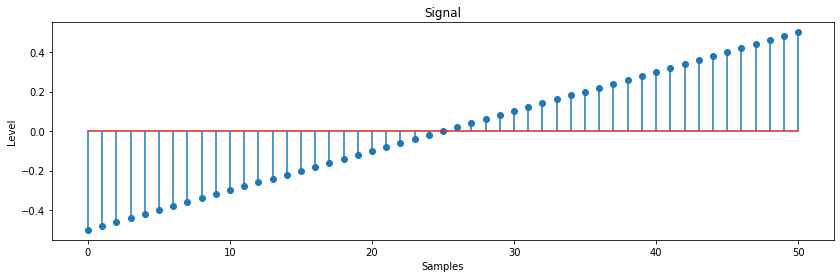

In [ ]:
x = np.arange(0, 1.02, 0.02) - 0.5
plt.stem(x, use_line_collection=True);
plt.title('Signal');
plt.ylabel('Level');
plt.xlabel('Samples');

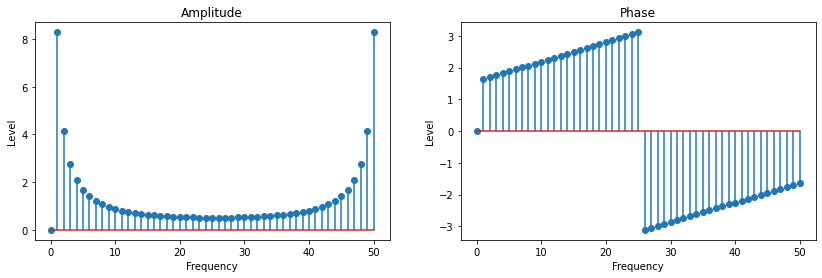

In [ ]:
X = DFT_slow(x);
plt.subplot(1,2,1);
plt.stem(abs(X), use_line_collection=True);
plt.title('Amplitude');
plt.ylabel('Level');
plt.xlabel('Frequency');
plt.subplot(1,2,2);
plt.stem(np.angle(X), use_line_collection=True);
plt.title('Phase');
plt.ylabel('Level');
plt.xlabel('Frequency');

In [ ]:
# выведем несколько коэффициентов ДПФ
size = len(X)
print ('X[0] = ', X[0])
print ('X[1] = ', X[2])
print ('X[N-2] = ', X[size-2])

X[0] =  (8.881784197001252e-16+0j)
X[1] =  (-0.5100000000000002+4.118654895392874j)
X[N-2] =  (-0.5099999999999232-4.118654895392855j)


## 2. Принцип БПФ (FFT): использование симметрии в ДПФ

В 1965 году американские математики Д. Кули и Д. Тьюки предложили алгоритм БПФ, основанный на симметрии задачи.
Представим вектор $X_{N+k}$ на основе формулы прямого преобразования:

$$
\begin{align*}
X_{N + k} &=  \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
\end{align*}
$$

Здесь использовано, что $e^{2\pi~i~n}= 1$ для любого целого $n$.

Последняя строка указывает на симметрию ДПФ:

$$X_{N+k} = X_k.$$

По аналогии можно показать, что для любого целого i:

$$X_{k + i \cdot N} = X_k.$$

Алгоритм БПФ, предложенный Кули и Тьюки, предполагает поэтапное разделение вычислений на две меньшие части (с четными и нечетными номерами):

$$
\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align}
$$

Далее для каждого слагаемого можно использовать свойство симметрии, если учесть, что диапазон $k$ равен $0≤k<N$, а диапазон $n$ равен $0≤n<N / 2$, то есть для каждой подзадачи можно выполнить лишь половину вычислений.

Можно продолжать разбиение исходной последовательности до тех пор, пока возможно целочисленное деление последовательности на двойку (поэтому наибольшая эффективность алгоритма достигается на сигналов, размер которых является степенью двойки). В асимптотическом пределе этот рекурсивный подход требует примерно $N + 2N\log{2N}$ операций (то есть не $\mathcal{O}[N^2]$, а $\mathcal{O}[N\log N]$). 

Ниже представлена таблица, показывающая сравнение эффективности алгоритмов БПФ в сравнении с ДПФ. Количество выполняемых операций БПФ линейно зависит от длины последовательности N.

![](https://drive.google.com/uc?export=view&id=1OESKQ21WEzgFjJzLAucFU3pXoFx0cuFZ)

Из таблицы видно, что использование БПФ существенно экономит на количестве операций, причем, чем больше длина последовательности N, тем больше экономия. Допустим, что на выполнение 1 операции требуется 1 нс. Тогда при $N=10^6$ для вычисления ДПФ потребуется $10^{12}$ нс ~ 17 мин, а для вычисления БПФ только $40\times10^6$ нс, т.е. 40 мс (!). 


## 3. Использование встроенных алгоритмов FFT

Из-за важности Фурье-преобразования во многих областях Python содержит множество стандартных инструментов и оболочек для его вычисления. Обе наиболее популярные библиотеки - NumPy и SciPy - имеют оболочки из чрезвычайно хорошо протестированного пакета FFTPACK, которые находятся в подмодулях numpy.fft и scipy.fftpack соответственно. Стоит отметить, что алгоритм, стоящий за FFTPACK - реализация на Фортране с применением различных методов оптимизации.

Рассмотрим применение FFT-алгоритма, встроенного в библиотеку numpy, к нашему начальному сигналу $x$.

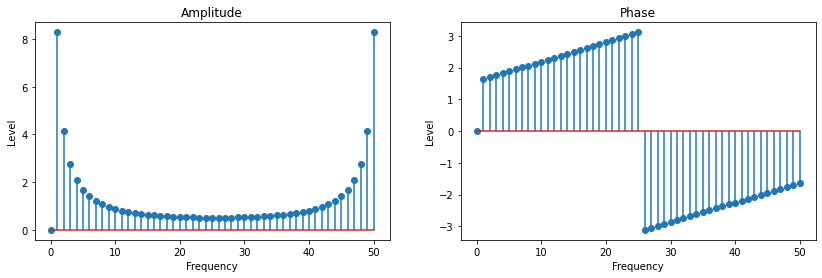

In [ ]:
X = np.fft.fft(x);
plt.subplot(1,2,1);
plt.stem(abs(X), use_line_collection=True);
plt.title('Amplitude');
plt.ylabel('Level');
plt.xlabel('Frequency');
plt.subplot(1,2,2);
plt.stem(np.angle(X), use_line_collection=True);
plt.title('Phase');
plt.ylabel('Level');
plt.xlabel('Frequency');

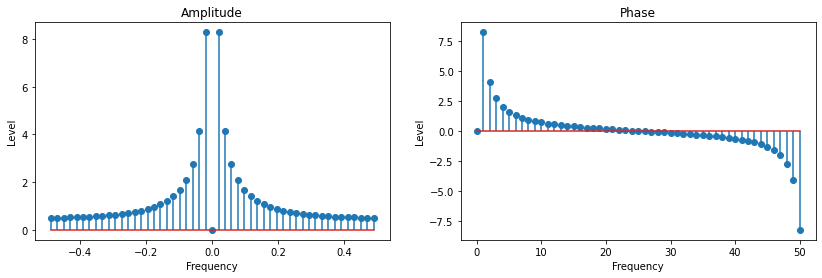

In [ ]:
# для удобства представления часто применяют функцию fftshift, которая реализует 
# cимметричный сдвиг нулевого отсчета FFT в центр
# или функуцию fftfreq, которая возвращает частоты преобразования Фурье
#Xs = np.fft.fftshift(X);
Fs = np.fft.fftfreq(len(x));
plt.subplot(1,2,1);
#plt.stem(abs(Xs));
plt.stem(Fs, abs(X), use_line_collection=True);
plt.title('Amplitude');
plt.ylabel('Level');
plt.xlabel('Frequency');
plt.subplot(1,2,2);
plt.stem(np.imag(X), use_line_collection=True);
plt.title('Phase');
plt.ylabel('Level');
plt.xlabel('Frequency');

Убедимся, что реализация алгоритма быстрого преобразования Фурье действительно ускоряет процесс разложения исходного сигнала. Для этого замерим скорость преобразования задананного вектора х обеими функциями:

In [ ]:
%timeit DFT_slow(x)
%timeit np.fft.fft(x)

1000 loops, best of 5: 226 µs per loop
The slowest run took 143.17 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 4.27 µs per loop


## 4. Спектр суммы гармонических сигналов

На примере сигнала, представляющего собой сумму трех гармонических функций и постоянной сотсавляющей, рассмотрим влияние частоты дискретизации на точность Фурье-преобразования. При этом также проверим аддитивный закон: спектр суммы сигналов равен сумме спектров сигналов.


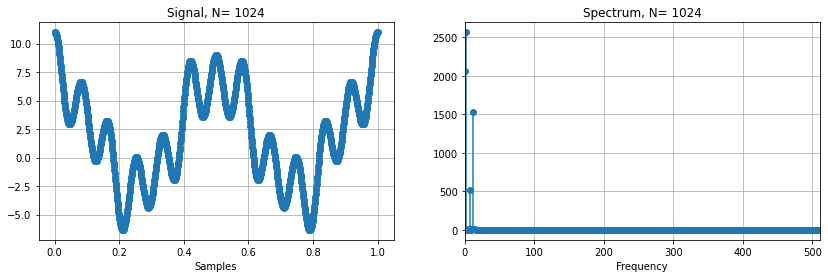

In [ ]:
N1 = 1024
t1 = np.linspace(0, 1, N1)

#  Задаем амплитуды и частоты
f1, f2, f3 = 2, 7, 12
A, A1, A2, A3 = 2, 5, 1, 3

# Сам сигнал
x1 = A + A1 * np.cos(2*np.pi*f1*t1) + A2 * np.cos(2*np.pi*f2*t1) + A3 * np.cos(2*np.pi*f3*t1)

# Рассчитываем быстрое преобразование Фурье
X1 = np.fft.fft(x1)

plt.subplot(1,2,1);
plt.title('Signal, N= %i' %N1)
plt.plot(t1,x1,linestyle='-',marker='o')
plt.xlabel('Samples')
plt.grid()
plt.subplot(1,2,2)
plt.stem(abs(X1), use_line_collection=True, basefmt='C0')
plt.xlim([0, N1//2-1]) #выводим половину коэффициентов разложения
plt.title('Spectrum, N= %i' %N1)
plt.xlabel('Frequency');
plt.grid()


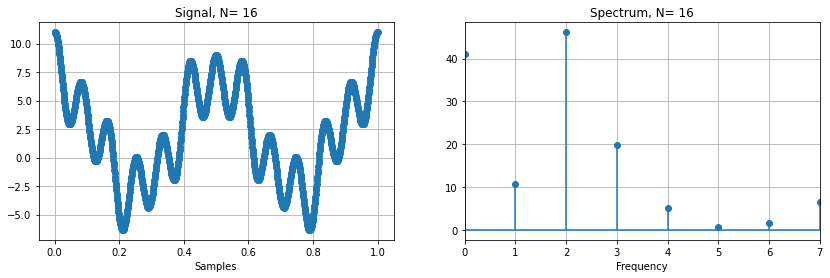

In [ ]:
# уменьшаем частоту дискретизации
N2 = 16
t2 = np.linspace(0, 1, N2)

x2 = A + A1 * np.cos(2*np.pi*f1*t2) + A2 * np.cos(2*np.pi*f2*t2) + A3 * np.cos(2*np.pi*f3*t2)

X2 = np.fft.fft(x2)

plt.subplot(1,2,1);
plt.title('Signal, N= %i' %N2)
plt.plot(t1,x1,linestyle='-',marker='o')
plt.xlabel('Samples')
plt.grid()
plt.subplot(1,2,2)
plt.stem(abs(X2), use_line_collection=True, basefmt='C0')
plt.xlim([0, N2//2-1]) #выводим половину коэффициентов разложения
plt.title('Spectrum, N= %i' %N2)
plt.xlabel('Frequency')
plt.grid()



## 5. Дополнение нулями (Zero Padding)

Из примера выше становится ясно, что разрешение преобразования Фурье зависит от размера данных (длины вектора *x*). Таким образом, можно предположить, что искусственное увеличение размера массива данных приведет к увеличению частотного разрешения результатов FFT. Речь идет не о добавлении новых данных, а о дополнении имеющегося массива нулями (или другой константой). Такой процесс называют *zero padding*.

Предположим, что у нас есть некий сигнал в $\mathbb{C}^N$ с $N=256$. Тогда частотное разрешение преобразования Фурье 

$$
    \Delta = 2\pi/256 \approx 0.0245
$$

Зададим сигнал, составленный из двух синусоид, разделенных на более, чем $\Delta$, и рассмотрим его спектр:

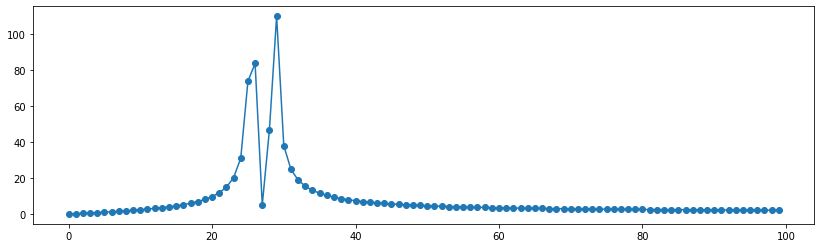

In [ ]:
N = 256
Delta = 2*np.pi / N
n = np.arange(0, N)

# основная частота сигнала
omega = 2*np.pi / 10 

x = np.cos(omega * n) + np.cos((omega + 3*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100],linestyle='-',marker='o'); #выводим первые 100 коэффициентов преобразования

Как видно, две частоты хорошо различимы на преобразовании. Теперь рассмотрим сигнал, в котором частоты синусоид разделены меньше, чем на $\Delta$: 

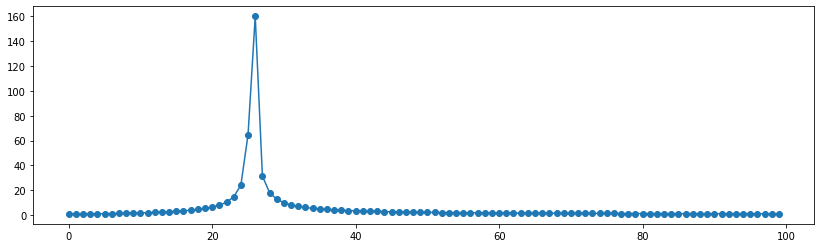

In [ ]:
x = np.cos(omega * n) + np.cos((omega + 0.5*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100],linestyle='-',marker='o')

В данном случае преобразование Фурье не может разрешить обе частоты. Попробуем дополнить исходный массив данных нулями и убедимся, что результатом преобразования Фурье будет по-прежнему один пик: 

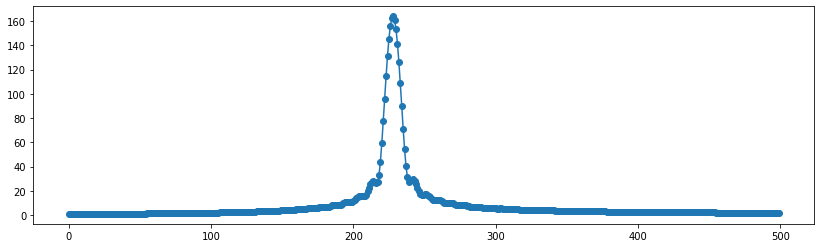

In [ ]:
xzp = np.concatenate((x, np.zeros(2000)))
plt.plot(abs(np.fft.fft(xzp))[:500],linestyle='-',marker='o');